In [85]:
import os 
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
grok_api_key = os.getenv("GROQ_API_KEY")

In [86]:
llm = ChatGroq(model="openai/gpt-oss-120b", api_key=grok_api_key)
llm.invoke("HELLO there")

AIMessage(content='Hello! How can I help you today?', additional_kwargs={'reasoning_content': 'We need to respond. The user says "HELLO there". We just greet back. Should be friendly.'}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 74, 'total_tokens': 115, 'completion_time': 0.081681672, 'prompt_time': 0.002873125, 'queue_time': 0.046995562, 'total_time': 0.084554797}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e10890e4b9', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--0d760302-5a68-4d4a-80c3-e4e60c338264-0', usage_metadata={'input_tokens': 74, 'output_tokens': 41, 'total_tokens': 115})

In [87]:
from typing import Annotated, List
import operator
from typing_extensions import Literal, TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage

In [88]:
# schema for strutured output to use in planning
class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="Brief Overview of the main topics and concepts of the section")


class Sections(BaseModel):
    sections:List[Section]=Field(
        description="Sections of the report"
    )

planner = llm.with_structured_output(Sections)

In [89]:
from langgraph.types import Send

# graph state
class State(TypedDict):
    topic: str
    sections: list[Section]
    completed_sections: Annotated[
        list, operator.add
    ]
    final_report: str

class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [90]:
def orchestrator(state: State):
    """ Orchestrator that generates a plan for the report"""

    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )
    print("Report Sections: ", report_sections)
    return {"sections": report_sections.section}

def llm_call(state:WorkerState):
    """ Worker writes a section of the report """
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
                ),
                HumanMessage(
                    content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
                ),
        ]
    )
    return {"completed_sections": [section.content]}

def assign_workers(state: State):
    """ Assign a worker to each section in the plan"""

    return [Send("llm_call", {"section": s}) for s in state["sections"]]

def synthesizer(state: State):
    """ Synthesize full report from sections"""

    completed_sections = state.get("completed_sections",[])

    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


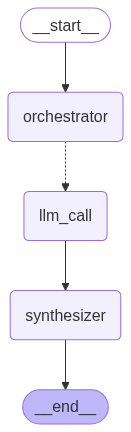

In [91]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
orchestrator_worker_builder = StateGraph(State)

orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges("orchestrator", assign_workers, ["llm_call"])
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

orchestrator_worker = orchestrator_worker_builder.compile()

display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))


In [92]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on gpt4.5"})

from IPython.display import Markdown
Markdown(state["final_report"])

Report Sections:  sections=[Section(name='Executive Summary', description='A concise overview of GPT‑4.5, its purpose, key capabilities, and the significance of the report for stakeholders.'), Section(name='Introduction', description='Background on large language models, evolution from GPT‑3 to GPT‑4, and the motivation behind developing GPT‑4.5.'), Section(name='Technical Architecture', description='Detailed description of the model’s architecture, tokenization, training data, compute resources, and any architectural improvements over GPT‑4.'), Section(name='Key Innovations', description='Discussion of the major advancements in GPT‑4.5 such as multimodal integration, enhanced context window, fine‑tuning methods, safety mechanisms, and efficiency optimizations.'), Section(name='Performance Evaluation', description='Benchmark results across standard NLP tasks (e.g., MMLU, BIG‑Bench, code generation) and comparison with GPT‑4 and competitor models.'), Section(name='Use Cases and Applicat

AttributeError: 'Sections' object has no attribute 'section'

In [57]:
state["final_report"]

'## Executive Summary\n\nGPT‑4.5 represents the latest evolution in OpenAI’s generative language models, delivering a measurable leap in performance, reliability, and adaptability across a broad spectrum of AI applications.\n\n- **Key Advancements**\n  - **Enhanced Contextual Understanding:** Expanded context window up to 64\u202fK tokens, enabling deeper comprehension of long-form documents, multi‑turn dialogues, and complex codebases.\n  - **Hybrid Multimodal Integration:** Seamless processing of text, images, and structured data within a single prompt, supporting richer interactions and more accurate cross‑modal reasoning.\n  - **Optimized Training Pipeline:** Leveraging a curated mixture of high‑quality web data, domain‑specific corpora, and reinforcement learning from human feedback (RLHF) to reduce hallucinations and improve factual consistency.\n  - **Energy‑Efficient Architecture:** Refined transformer design and quantization techniques cut inference latency by ~30\u202f% while